Create corpus and moral matrix.

In [21]:
%load_ext autoreload
%autoreload 2

import utils
from corpus import Corpus
from moral_matrix import MoralMatrix
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

logger = utils.setup_custom_logger("preprocessing")

# Prepare corpus and moral value matrix.
moral_matrix = MoralMatrix(
    "/home/raphael/Development/righteous-mind/data/moral_foundations_2.dic",
    logger
)

corpus = Corpus(
    "/home/raphael/Development/righteous-mind/data/users.pkl", 
    "/home/raphael/Development/righteous-mind/data/tweets.pkl", 
    moral_matrix, 
    logger
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Initializing moral matrix.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 14:42:00 INFO     Reading /home/raphael/Development/righteous-mind/data/users.pkl.
2018-12-29 1

Prepare model.

In [22]:
# load JS visualization code to notebook
shap.initjs()

df = corpus._users_df.sample(frac=1)
df.mv_scores = df.mv_scores.values / df.num_words.values
df.loc[df.party == "Libertarians", "party"] = "Republican Party"

x = pd.DataFrame(
    np.asarray([np.asarray(x) for x in df.mv_scores.values]), 
    columns=moral_matrix.get_moral_values()
)
class_names = ["Republican Party", "Democratic Party"]
le = preprocessing.LabelEncoder()
le.fit(class_names)
y = le.transform(df.party.values)

# train XGBoost model
model = xgb.train(
    {
        "objective": 'binary:logistic',
        "colsample_bytree": 0.7,
        "learning_rate": 0.05,
        "n_estimators": 6000,
        "n_jobs": 0,
        "nthread": 0
    }, 
    xgb.DMatrix(x, label=y)
)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

idx_republican = np.where(y == 0)
idx_democrat = np.where(y == 1)

[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[14:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

/home/raphael/.conda/envs/SMTA/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Show feature importance for Republicans.

In [24]:
shap.force_plot(explainer.expected_value, shap_values[idx_republican], x.iloc[idx_republican])

Show feature importance for Democrats.

In [26]:
shap.force_plot(explainer.expected_value, shap_values[idx_democrat], x.iloc[idx_democrat])

Feature dependency plots for Republicans.

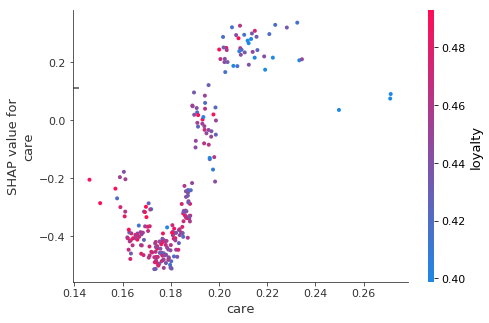

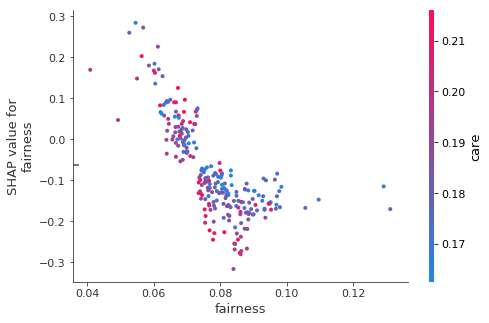

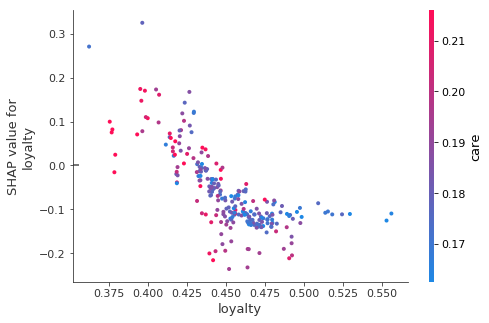

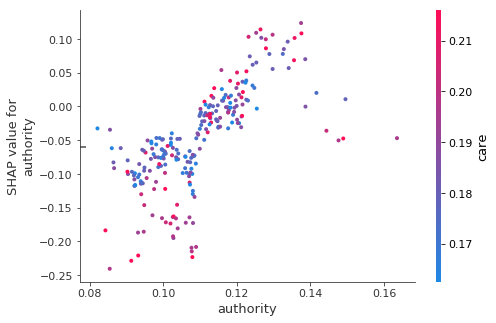

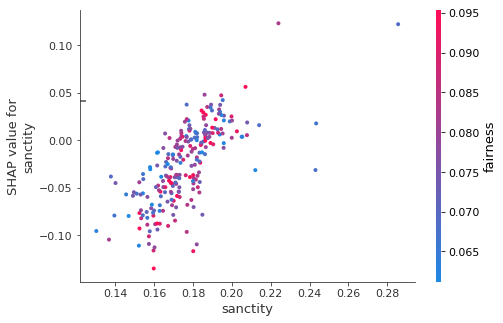

In [33]:
for name in moral_matrix.get_moral_values():
    shap.dependence_plot(name, shap_values[idx_republican], x.iloc[idx_republican])

Feature dependency plots for Democrats.

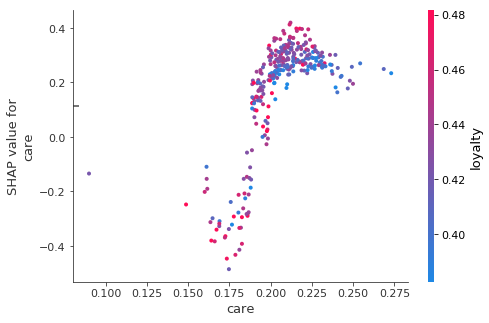

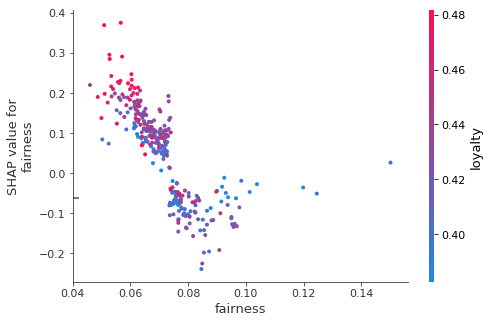

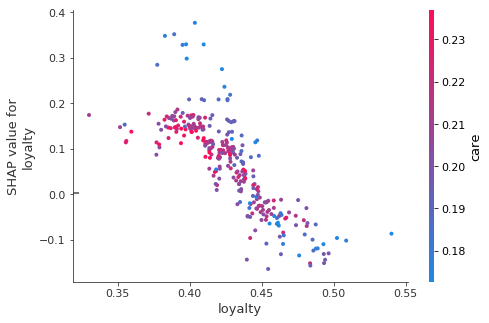

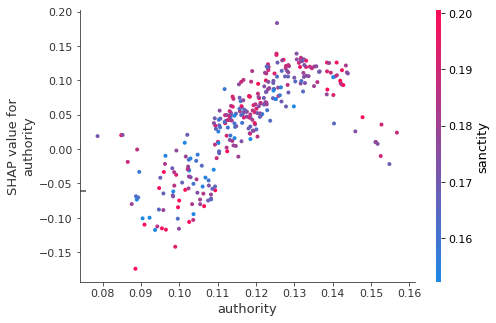

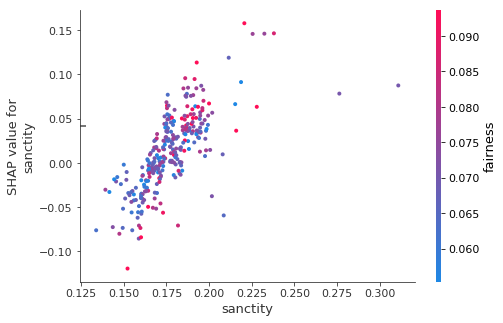

In [34]:
for name in moral_matrix.get_moral_values():
    shap.dependence_plot(name, shap_values[idx_democrat], x.iloc[idx_democrat])